# EfficientNet으로 하는 미세 조정을 통한 이미지 분류 (Image classification via fine-tuning with EfficientNet)

**저자:** [Yixing Fu](https://github.com/yixingfu)  
**생성일:** 2020/06/30  
**최종편집일:** 2023/07/10  
**설명:** Stanford Dogs 분류를 위해 이미지넷에 대해 사전 트레이닝된 가중치로 EfficientNet을 사용합니다.

## Keras 3

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

## 소개: EfficientNet이란?

[Tan and Le, 2019](https://arxiv.org/abs/1905.11946)에서 처음 소개된 EfficientNet은 이미지넷과 일반적인 이미지 분류 전이 학습 작업 모두에서 SOTA 정확도에 도달하는 가장 효율적인 모델(즉, 추론에 최소의 FLOPS가 필요함)중 하나입니다.

가장 작은 기본 모델은 훨씬 더 작은 모델로 SOTA에 가까운 정확도를 달성한 [MnasNet](https://arxiv.org/abs/1807.11626)과 유사합니다. 모델을 확장하는 휴리스틱 방식을 도입함으로써, EfficientNet은 다양한 규모에서 효율성과 정확성의 좋은 조합을 나타내는 모델 제품군(B0~B7)을 제공합니다. 이러한 확장 휴리스틱(복합 확장, 자세한 내용은 [Tan and Le, 2019](https://arxiv.org/abs/1905.11946) 참조)을 사용하면 효율성 지향 기본 모델(B0)이 모든 규모의 모델을 능가하는 동시에, 하이퍼파라미터에 대한 광범위한 그리드 검색을 피할 수 있습니다.

이 모델의 최신 업데이트 요약은 [여기](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)에서 확인할 수 있으며, 모델의 이미지넷 성능을 더욱 향상시키기 위해 다양한 보강 체계와 준지도 학습 접근법이 적용됩니다. 이러한 모델 확장은 모델 아키텍처를 변경하지 않고 가중치를 업데이트하여 사용할 수 있습니다.

B0~B7의 EfficientNet 버전
---------------------------------


_(이 섹션에서는 "복합 스케일링(compound scaling)"에 대한 자세한 내용을 제공하며, 모델 사용에만 관심이 있는 경우 건너뛸 수 있습니다)_

[원본 논문](https://arxiv.org/abs/1905.11946)을 보면 EfficientNet이 논문의 식 (3)과 같이 스케일링 계수를 임의로 선택해 만든 연속적인 모델군이라는 인상을 받을 수 있습니다. 그러나, 해상도, 깊이, 폭의 선택은 여러 가지 요인에 의해 제한됩니다:

* 해상도: 8, 16 등으로 나눌 수 없는 해상도는 일부 레이어의 경계 근처에서 제로 패딩이 발생하여 계산 리소스를 낭비합니다. 이는 특히 모델의 작은 변형에 적용되므로, B0 및 B1의 입력 해상도는 224 및 240으로 선택됩니다.

* 깊이와 너비: EfficientNet의 빌딩 블록은 채널 크기가 8의 배수일 것을 요구합니다.

* 리소스 제한: 메모리 제한으로 인해 깊이와 너비가 계속 증가할 수 있는 경우 해상도에 병목 현상이 발생할 수 있습니다. 이러한 상황에서는, 깊이 및/또는 너비를 늘리되 해상도를 유지하면 성능이 향상될 수 있습니다.

따라서, EfficientNet 모델의 각 변형 모델의 깊이, 너비 및 해상도는 수작업으로 선택되어 좋은 결과를 내는 것으로 입증되었지만, 복합 스케일링 공식과 크게 다를 수 있습니다. 따라서, keras 구현(아래에 자세히 설명되어 있음)에서는 너비/깊이/해상도 매개변수의 임의 선택을 허용하는 대신, 이 8가지 모델인 B0~B7만 제공합니다.

Keras EfficientNet 구현
------------------------------------

Keras 2.3 버전부터 Keras와 함께 EfficientNet B0~B7의 구현이 제공되었습니다. ImageNet으로부터의 1000개의 이미지 클래스를 분류하는데 EfficientNetB0을 사용하려면, 다음을 실행하세요:

```python
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')
```

이 모델은 `(224, 224, 3)` 모양의 입력 이미지를 사용하며, 입력 데이터는 `[0, 255]` 범위여야 합니다. 정규화는 모델의 일부로 포함됩니다.

이미지넷에 대해 EfficientNet을 트레이닝하려면 엄청난 양의 리소스와 모델 아키텍처 자체에 포함되지 않은 몇 가지 기술이 필요하기 때문입니다. 따라서 Keras 구현은 기본적으로 [AutoAugment](https://arxiv.org/abs/1805.09501)을 통한 트레이닝을 통해 얻은 사전 트레이닝된 가중치를 로드합니다.

B0~B7 기본 모델의 경우, 입력 모양이 다릅니다. 다음은 각 모델에 대해 기대되는 입력 모양 목록입니다:

| 베이스 모델 | 해상도 |
|--|--|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

모델이 전이 학습을 목적으로 하는 경우, Keras 구현은 최상위 레이어를 제거하는 옵션을 제공합니다:

```python
model = EfficientNetB0(include_top=False, weights='imagenet')
```

이 옵션은 두 번째 레이어의 1280개 특성을 1000개의 ImageNet 클래스에 대한 예측으로 바꾸는 최종 `Dense` 레이어를 제외합니다. 최상위 레이어를 커스텀 레이어로 대체하면 전이 학습 워크플로우에서 EfficientNet을 특성 추출기로 사용할 수 있습니다.

모델 생성자에서 주목할 만한 또 다른 인수는 [확률적 깊이(stochastic depth)](https://arxiv.org/abs/1603.09382)를 담당하는 드롭아웃 비율을 제어하는 `drop_connect_rate`입니다. 이 매개변수는 미세 조정에서 추가 정규화를 위한 토글 역할을 하지만, 로드된 가중치에는 영향을 미치지 않습니다. 예를 들어, 더 강력한 정규화가 필요한 경우, 다음을 사용해 보세요:

```python
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
```

기본값은 0.2입니다.

예시: Stanford Dogs를 위한 EfficientNetB0
------------------------------------------

EfficientNet은 광범위한 이미지 분류 작업을 수행할 수 있습니다. 따라서, 전이 학습을 위한 좋은 모델입니다. 엔드투엔드 예시로, [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html) 데이터 세트에 대해 사전 트레이닝된 EfficientNetB0을 사용해 보여드리겠습니다.

셋업 및 데이터 로드
----------------------

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE는 EfficientNet 모델 선택에 따라 결정됩니다.
IMG_SIZE = 224
BATCH_SIZE = 64

### 데이터 로드

여기서는 [tensorflow\_datasets](https://www.tensorflow.org/datasets)(이하 TFDS)에서 데이터를 로드합니다. Stanford Dogs 데이터 세트는 TFDS에서 [stanford\_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)로 제공됩니다. 120개 견종에 속하는 20,580개의 이미지(트레이닝용 12,000개, 테스트용 8,580개)가 포함되어 있습니다.

아래 `dataset_name`을 변경하면, [cifar10](https://www.tensorflow.org/datasets/catalog/cifar10), [cifar100](https://www.tensorflow.org/datasets/catalog/cifar100), [food101](https://www.tensorflow.org/datasets/catalog/food101) 등 TFDS의 다른 데이터 세트에 대해서도 이 노트북을 사용해 볼 수 있습니다. 이미지가 EfficientNet 입력 크기보다 훨씬 작은 경우, 입력 이미지를 업샘플링하면 됩니다. [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)에서 입력 이미지가 작아도 해상도가 높아지면 전이 학습 결과가 더 좋아진다는 것을 보여주었습니다.

In [3]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSFH9CQ/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSFH9CQ/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


데이터 세트에 다양한 크기의 이미지가 포함되어 있는 경우, 우리는 공유되는 크기로 크기를 조정해야 합니다. Stanford Dogs 데이터 세트에는 최소 200x200픽셀 크기의 이미지만 포함되어 있습니다. 여기서 우리는 이미지의 크기를 EfficientNet에 필요한 입력 크기로 조정합니다.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))


### 데이터 시각화

다음 코드는 처음 9개의 이미지와 해당 레이블을 보여줍니다.

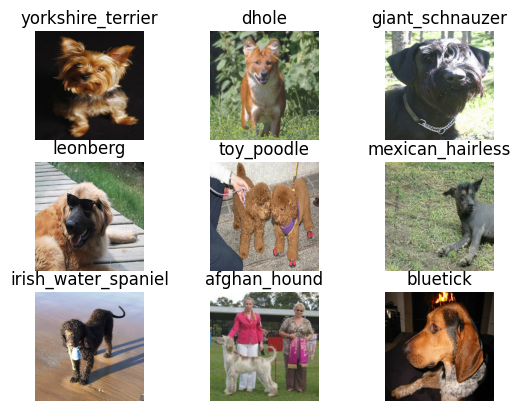

In [5]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### 데이터 보강

이미지 보강을 위해 전처리 레이어 API를 사용할 수 있습니다.

In [6]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

이 `Sequential` 모델 객체는 나중에 빌드하는 모델의 일부로서 사용할 수도 있고, 모델에 데이터를 입력하기 전에 데이터를 사전 처리하는 함수로 사용할 수도 있습니다. 함수로 사용하면 보강된 이미지를 쉽게 시각화할 수 있습니다. 여기에서는 주어진 그림의 보강 결과의 9가지 예를 보여줍니다.

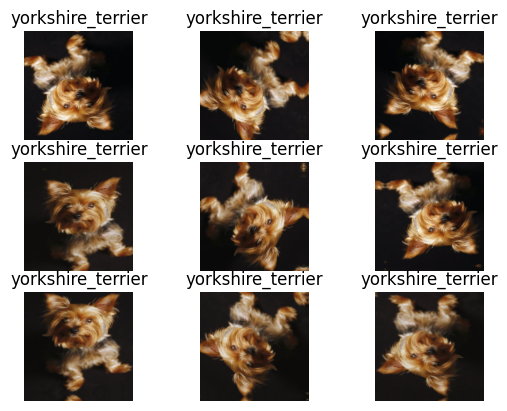

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

### 입력 준비

입력 데이터와 보강이 제대로 작동하는지 확인하면, 트레이닝을 위한 데이터 세트를 준비합니다. 입력 데이터의 크기를 균일한 `IMG_SIZE`로 조정합니다. 레이블은 one-hot(일명 카테고리형) 인코딩에 넣습니다. 데이터 세트가 배치 처리됩니다.

> 참고: `prefetch`와 `AUTOTUNE`은 경우에 따라 성능을 향상시킬 수 있지만, 환경과 사용되는 특정 데이터 세트에 따라 다릅니다. 데이터 파이프라인 성능에 대한 자세한 내용은 이 [가이드](https://www.tensorflow.org/guide/data_performance)를 참조하세요.

In [8]:
# One-hot/카테고리형 인코딩 One-hot
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

처음부터 모델 트레이닝하기
-----------------------------

처음부터 초기화된, 120개의 출력 클래스가 있는 EfficientNetB0을 빌드합니다:

> 참고: 정확도가 매우 느리게 증가하며, 과적합할 수 있습니다.

In [9]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 130ms/step - accuracy: 0.0119 - loss: 5.0840 - val_accuracy: 0.0058 - val_loss: 5.0710
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0178 - loss: 4.6863 - val_accuracy: 0.0127 - val_loss: 5.0756
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0281 - loss: 4.4961 - val_accuracy: 0.0286 - val_loss: 4.5197
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0384 - loss: 4.3559 - val_accuracy: 0.0361 - val_loss: 5.9777
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0482 - loss: 4.2346 - val_accuracy: 0.0372 - val_loss: 5.6137
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0599 - loss: 4.1403 - val_accuracy: 0.0571 - val_loss: 4.4301
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0741 - loss: 4.0370 - val_accuracy: 0.0615 - val_loss: 4.5577
Epoch 8/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.0797 - loss: 3

모델 트레이닝은 비교적 빠릅니다. 따라서, 처음부터 원하는 데이터 세트에 대해 EfficientNet을 트레이닝하는 것이 쉬워 보일 수 있습니다. 그러나, 소규모 데이터 세트, 특히 CIFAR-100과 같이 해상도가 낮은 데이터 세트에 대해, EfficientNet을 트레이닝할 경우, 과적합이라는 중대한 문제에 직면하게 됩니다.

따라서 처음부터 트레이닝하려면 하이퍼파라미터를 매우 신중하게 선택해야 하며, 적절한 정규화를 찾기가 어렵습니다. 또한 리소스도 훨씬 더 많이 요구됩니다. 트레이닝과 검증 정확도를 그래프로 그려보면, 검증 정확도가 낮은 값에서 정체되는 것을 알 수 있습니다.

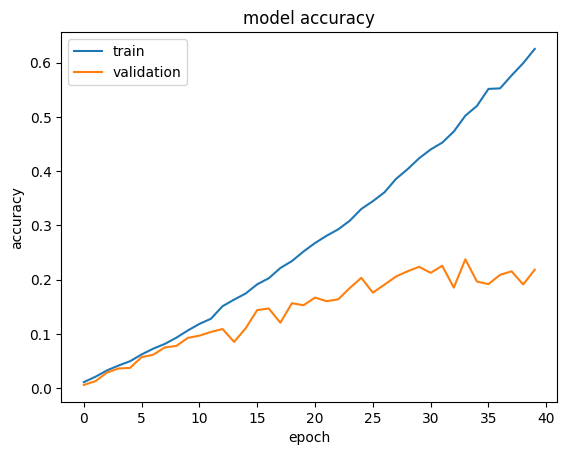

In [10]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

사전 트레이닝된 가중치를 통한 전이 학습
------------------------------------------

여기서는 미리 트레이닝된 이미지넷 가중치로 모델을 초기화하고, 자체 데이터 세트에서 미세 조정합니다.

In [11]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # 사전 트레이닝된 웨이트 동결
    model.trainable = False

    # 톱만 다시 빌드
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # 컴파일
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

전이 학습의 첫 번째 단계는 모든 레이어를 동결하고 최상위 레이어만 트레이닝하는 것입니다. 이 단계에서는, 비교적 큰 학습률(1e-2)을 사용할 수 있습니다. 일반적으로 검증 정확도와 손실이 트레이닝 정확도와 손실보다 낫다는 점에 유의하세요. 이는 정규화가 강력하여, 트레이닝 시의 메트릭만 억제하기 때문입니다.

학습률 선택에 따라 수렴에 최대 50개의 에포크가 소요될 수 있습니다. 이미지 보강 레이어를 적용하지 않은 경우, 검증 정확도는 최대 60%에 불과할 수 있습니다.

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.2663 - loss: 4.3671 - val_accuracy: 0.6714 - val_loss: 1.1059
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.4849 - loss: 2.1022 - val_accuracy: 0.7247 - val_loss: 0.9034
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5498 - loss: 1.6708 - val_accuracy: 0.7266 - val_loss: 0.9067
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5575 - loss: 1.6268 - val_accuracy: 0.7345 - val_loss: 0.8629
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5817 - loss: 1.5340 - val_accuracy: 0.7499 - val_loss: 0.8287
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5894 - loss: 1.4628 - val_accuracy: 0.7420 - val_loss: 0.8762
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5796 - loss: 1.5170 - val_accuracy: 0.7432 - val_loss: 0.8485
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━

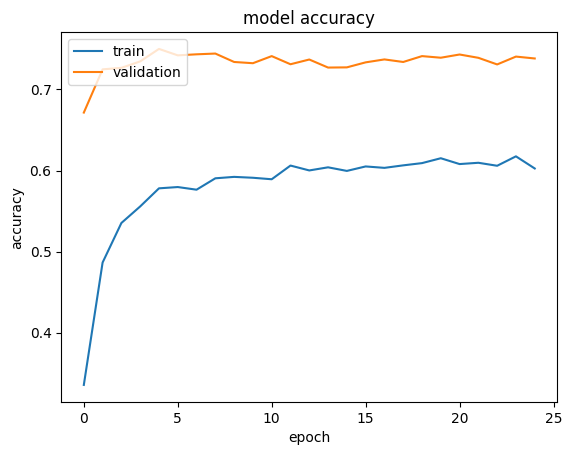

In [12]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

두 번째 단계는 여러 레이어의 동결을 해제하고 더 작은 학습률을 사용하여 모델을 맞추는 것입니다. 이 예에서는 모든 레이어를 동결 해제하는 것을 보여드리지만, 특정 데이터 세트에 따라 전체 레이어 중 일부만 동결 해제하는 것이 바람직할 수도 있습니다.

사전 트레이닝된 모델을 사용한 특성 추출이 충분히 잘 작동하는 경우, 이 단계는 검증 정확도를 매우 제한적으로 향상시킬 수 있습니다. 우리의 경우에는 이미 ImageNet 사전 트레이닝된 모델이 많은 양의 개에 노출되어 있었기 때문에 약간의 개선만 있었습니다.

반면, 이미지넷으로부터의 다른 데이터 세트에 대해 사전 트레이닝된 가중치를 사용하는 경우, 특성 추출기 역시 상당 부분 조정해야 하므로, 이 미세 조정 단계가 매우 중요할 수 있습니다. 이러한 상황은 CIFAR-100 데이터 세트를 선택하면 확인할 수 있는데, 이 경우 미세 조정을 통해 검증 정확도가 약 10% 향상되어 `EfficientNetB0`에서 80%를 통과할 수 있습니다.

모델 동결/해제에 대한 참고 사항: `Model`의 `trainable`을 설정하면 `Model`에 속한 모든 레이어가 동시에 동일한 `trainable` 속성으로 설정됩니다. 각 레이어는 레이어 자체와 레이어가 포함된 모델이 모두 트레이닝 가능한 경우에만 트레이닝 가능할 수 있습니다. 따라서, 모델을 부분적으로 동결/동결 해제해야 하는 경우, 모델의 `trainable` 속성이 `True`로 설정되어 있는지 확인해야 합니다.

Epoch 1/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.6294 - loss: 1.3397 - val_accuracy: 0.7494 - val_loss: 0.9049
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.6456 - loss: 1.2481 - val_accuracy: 0.7620 - val_loss: 0.8738
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.6595 - loss: 1.1836 - val_accuracy: 0.7646 - val_loss: 0.8547
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.6681 - loss: 1.1777 - val_accuracy: 0.7671 - val_loss: 0.8404


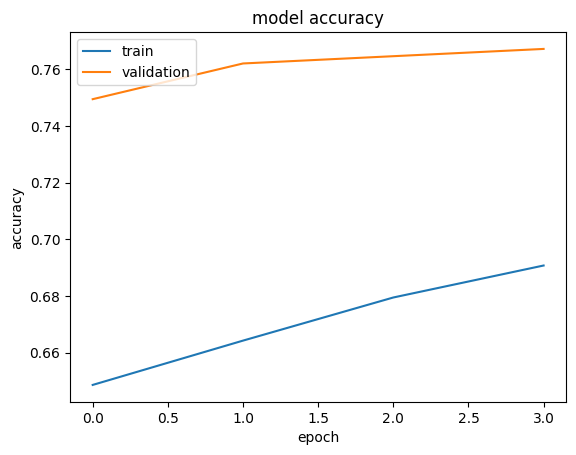

In [13]:
def unfreeze_model(model):
    # 상위 20개 레이어는 동결 해제하고 BatchNorm 레이어는 고정된 상태로 둡니다.
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

### EfficientNet 미세 조정을 위한 팁

동결 해제 레이어에서:

* `BatchNormalization` 레이어는 동결 상태로 유지해야 합니다. ([자세한 내용]({% link docs/04-guides/14-transfer_learning.md %})) 트레이닝 가능한 상태로 전환하면, 동결 해제 후 첫 번째 에포크에서 정확도가 크게 떨어집니다.
* 경우에 따라서는 모든 레이어를 동결 해제하는 대신, 일부 레이어만 동결 해제하는 것이 유리할 수 있습니다. 이렇게 하면 B7과 같은 큰 모델로 이동할 때 미세 조정이 훨씬 빨라집니다.
* 각 블록을 모두 켜거나 꺼야 합니다. 이는 아키텍처에 각 블록의 첫 번째 레이어에서 마지막 레이어까지 shortcut이 포함되어 있기 때문입니다. 블록을 존중하지 않으면 최종 성능도 크게 저하됩니다.

EfficientNet을 활용하기 위한 몇 가지 다른 팁:

* 특히 데이터가 적거나 클래스 수가 적은 작업의 경우, EfficientNet의 변형이 클수록 성능이 향상되지 않습니다. 이러한 경우, 더 큰 EfficientNet 변형을 선택할수록, 하이퍼파라미터를 조정하기가 더 어려워집니다.
* EMA(지수이동평균, Exponential Moving Average)는 EfficientNet을 처음부터 트레이닝하는 데는 매우 유용하지만, 전이 학습에는 그다지 유용하지 않습니다.
* 전이 학습에는 원본 논문에서와 같은 RMSprop 설정을 사용하지 마세요. 전이 학습을 하기에는 모멘텀과 학습률이 너무 높습니다. 사전 트레이닝된 가중치가 쉽게 손상되어 손실이 커질 수 있습니다. 간단한 확인 방법은 손실(카테고리형 교차 엔트로피)이 같은 에포크 이후 log(NUM\_CLASSES)보다 현저히 커지는지 확인하는 것입니다. 만약 그렇다면, 초기 학습률/모멘텀이 너무 높다는 뜻입니다.
* 배치 크기가 작을수록 정규화를 효과적으로 제공하기 때문에, 검증 정확도에 도움이 될 수 있습니다.
